# Bayesian Decision Theory: Decisions via Risk (Loss) and Utility

 This notebook illustrates **Bayesian decision theory**: when you have uncertainty about the *true state of the world*,
 you should choose the action that minimizes **expected posterior risk** (or equivalently maximizes expected utility).

 We'll go step-by-step:
 1) Define states, actions, and a loss/utility table
 2) Compute the posterior with Bayes' rule
 3) Compute posterior expected risk for each action
 4) Derive decision rules (thresholds)
 5) Visualize how different losses/utilities change the optimal decision
 6) A small simulation to confirm the theory

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")


def normalize(probs):
    probs = np.asarray(probs, dtype=float)
    s = probs.sum()
    if s == 0:
        raise ValueError("Cannot normalize: sum is zero.")
    return probs / s

# 1) Core idea (in one equation)

 Let:
 - states:  θ ∈ {θ1, θ2, ...}  (what is actually true)
 - actions: a ∈ {a1, a2, ...} (what you choose to do)
 - loss:    L(a, θ)           (how bad action a is if θ is true)

 After observing data D, you have a posterior P(θ | D).

 **Posterior expected risk** of an action a:

     R(a | D) = E[L(a, θ) | D] = Σ_θ L(a, θ) P(θ | D)

 **Bayes action**:

     a*(D) = argmin_a R(a | D)

 If you prefer utilities U(a, θ) (higher is better), maximize expected utility instead:

     a*(D) = argmax_a Σ_θ U(a, θ) P(θ | D)

 We'll work mostly with losses; it's the same story with a sign flip.

# 2) A concrete binary example: decide "Treat" vs "Don't treat"

 Suppose a patient may have a disease.

 - State θ ∈ {Disease, NoDisease}
 - Action a ∈ {Treat, NoTreat}

 Losses:
 - If you treat when diseased: small cost (side effects, inconvenience)
 - If you treat when not diseased: unnecessary treatment cost
 - If you don't treat when diseased: big cost (missed disease)
 - If you don't treat when not diseased: near zero

 We'll encode this in a loss matrix.

In [34]:
states = ["Disease", "NoDisease"]
actions = ["Treat", "NoTreat"]

# Loss table L[action, state]
# Rows: actions, Columns: states
L = pd.DataFrame(
    [[1.0, 2.0],  # Treat: (Disease, NoDisease)
     [20.0, 0.0]],  # NoTreat: (Disease, NoDisease)
    index=actions,
    columns=states
)
L

,Disease,NoDisease
Treat,1.0,2.0
NoTreat,20.0,0.0


## Interpreting the loss table
 - Treat & Disease: loss = 1
 - Treat & NoDisease: loss = 2
 - NoTreat & Disease: loss = 20  (very bad)
 - NoTreat & NoDisease: loss = 0

 Next we need a posterior probability P(Disease | data).
 We'll obtain it from a diagnostic test using Bayes' rule.

# 3) Bayes' rule for a diagnostic test

 Let:
 - Prior prevalence: P(Disease) = π
 - Sensitivity:      P(Test+ | Disease)
 - Specificity:      P(Test- | NoDisease)

 From these we can compute the posterior:
 - P(Disease | Test+)
 - P(Disease | Test-)

 Then Bayesian decision theory tells us which action (Treat/NoTreat) minimizes posterior expected loss.

In [35]:
def posterior_disease_given_test(prior, sensitivity, specificity, test_result):
    """
    prior: P(Disease)
    sensitivity: P(Test+ | Disease)
    specificity: P(Test- | NoDisease)
    test_result: '+' or '-'
    """
    prior = float(prior)
    p_d = prior
    p_nd = 1 - prior

    if test_result == '+':
        p_t_given_d = sensitivity
        p_t_given_nd = 1 - specificity
    elif test_result == '-':
        p_t_given_d = 1 - sensitivity
        p_t_given_nd = specificity
    else:
        raise ValueError("test_result must be '+' or '-'")

    unnorm = np.array([p_d * p_t_given_d, p_nd * p_t_given_nd])
    post = normalize(unnorm)
    return {"Disease": post[0], "NoDisease": post[1]}


def posterior_expected_risk(loss_table, posterior_over_states):
    """
    loss_table: DataFrame with index=actions and columns=states
    posterior_over_states: dict state->prob (must match columns)
    returns: Series action -> expected loss
    """
    p = pd.Series(posterior_over_states).reindex(loss_table.columns)
    return loss_table.dot(p)


def bayes_action(loss_table, posterior_over_states):
    risks = posterior_expected_risk(loss_table, posterior_over_states)
    return risks.idxmin(), risks


# Example parameters
pi = 0.01  # prior prevalence
sens = 0.90
spec = 0.95

post_plus = posterior_disease_given_test(pi, sens, spec, '+')
post_minus = posterior_disease_given_test(pi, sens, spec, '-')

post_plus, post_minus

({'Disease': 0.15384615384615374, 'NoDisease': 0.8461538461538463},
 {'Disease': 0.0010621348911311734, 'NoDisease': 0.9989378651088688})

In [36]:
action_plus, risks_plus = bayes_action(L, post_plus)
action_minus, risks_minus = bayes_action(L, post_minus)

pd.DataFrame(
    {"posterior(Test+)": post_plus, "posterior(Test-)": post_minus}), action_plus, action_minus, risks_plus, risks_minus

(           posterior(Test+)  posterior(Test-)
 Disease            0.153846          0.001062
 NoDisease          0.846154          0.998938,
 'Treat',
 'NoTreat',
 Treat      1.846154
 NoTreat    3.076923
 dtype: float64,
 Treat      1.998938
 NoTreat    0.021243
 dtype: float64)

## What happened?
 Even with a positive test, the posterior might still be moderate if the disease is rare (small prior).
 Bayesian decision theory *doesn't* say "treat if test is positive".
 It says:

 > Treat if the **expected loss** of treating is smaller than the expected loss of not treating.

 That depends on:
 - the posterior probability (from Bayes)
 - the loss/utility numbers (your preferences / costs)

# 4) Deriving a decision threshold (binary states, two actions)

 Let p = P(Disease | data).

 Expected loss:
 - R(Treat)   = L(Treat,D)*p + L(Treat,NoD)*(1-p)
 - R(NoTreat) = L(NoTreat,D)*p + L(NoTreat,NoD)*(1-p)

 Choose Treat if R(Treat) < R(NoTreat).

 This inequality can be rearranged into a **threshold rule**:
     Treat if p > p*

 We'll compute p* from the loss table.

In [37]:
def treatment_threshold(loss_table):
    """
    For actions Treat/NoTreat and states Disease/NoDisease, returns p* such that:
    choose Treat if p = P(Disease|data) > p*
    """
    LT_D = loss_table.loc["Treat", "Disease"]
    LT_ND = loss_table.loc["Treat", "NoDisease"]
    LNT_D = loss_table.loc["NoTreat", "Disease"]
    LNT_ND = loss_table.loc["NoTreat", "NoDisease"]

    # Solve for p in: LT_D*p + LT_ND*(1-p) < LNT_D*p + LNT_ND*(1-p)
    # -> (LT_D - LT_ND - LNT_D + LNT_ND) * p < (LNT_ND - LT_ND)
    a = (LT_D - LT_ND - LNT_D + LNT_ND)
    b = (LNT_ND - LT_ND)

    if a == 0:
        return np.nan  # degenerate: both actions have equal slope in p
    return b / a


p_star = treatment_threshold(L)
p_star

0.09523809523809523

In [38]:
def treatment_threshold(loss_table):
    """
    For actions Treat/NoTreat and states Disease/NoDisease, returns p* such that:
    choose Treat if p = P(Disease|data) > p*
    """
    LT_D = loss_table.loc["Treat", "Disease"]
    LT_ND = loss_table.loc["Treat", "NoDisease"]
    LNT_D = loss_table.loc["NoTreat", "Disease"]
    LNT_ND = loss_table.loc["NoTreat", "NoDisease"]

    # Solve for p in: LT_D*p + LT_ND*(1-p) < LNT_D*p + LNT_ND*(1-p)
    # -> (LT_D - LT_ND - LNT_D + LNT_ND) * p < (LNT_ND - LT_ND)
    a = (LT_D - LT_ND - LNT_D + LNT_ND)
    b = (LNT_ND - LT_ND)

    if a == 0:
        return np.nan  # degenerate: both actions have equal slope in p
    return b / a


p_star = treatment_threshold(L)
p_star

0.09523809523809523

## Interpret the threshold
 If `p*` is small, you'll treat even when disease probability is low (because missing disease is very costly).
 If `p*` is large, you'll treat only when you are quite sure (because treatment is costly/unpleasant).

 Let's confirm the threshold rule numerically by sweeping p from 0 to 1.

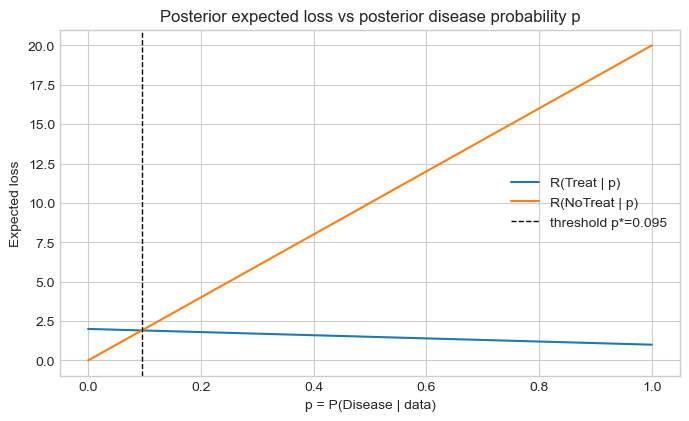

In [39]:
ps = np.linspace(0, 1, 501)
risk_treat = L.loc["Treat", "Disease"] * ps + L.loc["Treat", "NoDisease"] * (1 - ps)
risk_notreat = L.loc["NoTreat", "Disease"] * ps + L.loc["NoTreat", "NoDisease"] * (1 - ps)

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(ps, risk_treat, label="R(Treat | p)")
ax.plot(ps, risk_notreat, label="R(NoTreat | p)")

ax.axvline(p_star, color="black", linestyle="--", linewidth=1, label=f"threshold p*={p_star:.3f}")
ax.set_title("Posterior expected loss vs posterior disease probability p")
ax.set_xlabel("p = P(Disease | data)")
ax.set_ylabel("Expected loss")
ax.legend()
plt.show()

# 5) How utilities (or different loss choices) change the decision

 Let's compare three loss settings:
 1) Symmetric-ish: treating unnecessarily is about as bad as missing (not realistic medically, but good for intuition)
 2) High penalty for missing disease (miss cost high)
 3) High penalty for unnecessary treatment (treat cost high)

 We'll compute the corresponding thresholds p* and visualize them.

In [40]:
loss_symmetric = pd.DataFrame(
    [[1.0, 1.0],
     [2.0, 0.0]],
    index=actions, columns=states
)

loss_miss_is_very_bad = pd.DataFrame(
    [[1.0, 2.0],
     [100.0, 0.0]],
    index=actions, columns=states
)

loss_treatment_is_very_bad = pd.DataFrame(
    [[1.0, 20.0],
     [20.0, 0.0]],
    index=actions, columns=states
)

candidates = {
    "symmetric-ish": loss_symmetric,
    "miss is very bad": loss_miss_is_very_bad,
    "treatment is very bad": loss_treatment_is_very_bad,
    "original": L,
}

thresholds = {name: treatment_threshold(tbl) for name, tbl in candidates.items()}
pd.Series(thresholds).sort_values()

miss is very bad         0.019802
original                 0.095238
symmetric-ish            0.500000
treatment is very bad    0.512821
dtype: float64

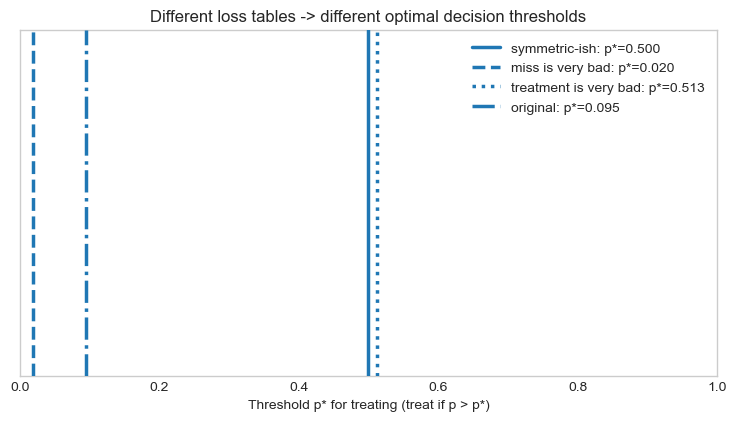

In [41]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.style.use("seaborn-v0_8-whitegrid")

fig, ax = plt.subplots(figsize=(9, 4.5))
# Use Matplotlib's "tab10" palette (high-contrast, distinct)
colors = plt.cm.tab10.colors
ax.set_prop_cycle(color=colors)

linestyles = ["-", "--", ":", "-."]

for (name, tbl), ls in zip(candidates.items(), linestyles):
    p_star = treatment_threshold(tbl)
    ax.axvline(
        p_star,
        linestyle=ls,
        linewidth=2.5,
        alpha=1.0,
        zorder=10,
        label=f"{name}: p*={p_star:.3f}",
    )
# Ensure background isn't fighting you
ax.set_facecolor("white")
fig.patch.set_facecolor("white")

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.grid(False)

ax.set_title("Different loss tables -> different optimal decision thresholds")
ax.set_xlabel("Threshold p* for treating (treat if p > p*)")
ax.legend(loc="upper right")
plt.show()

# 6) Connecting Bayes + decisions: from test result to action

 A diagnostic test gives you a posterior p = P(Disease | Test result).
 Then the loss table gives you a threshold p*.
 Put together:

 - Compute p from Bayes
 - Treat if p > p*

 Let's compute p(Test+) and p(Test-) and see where they fall relative to the threshold.

In [42]:
def posterior_p_disease(prior, sensitivity, specificity, test_result):
    post = posterior_disease_given_test(prior, sensitivity, specificity, test_result)
    return post["Disease"]


p_plus = posterior_p_disease(pi, sens, spec, '+')
p_minus = posterior_p_disease(pi, sens, spec, '-')
p_star = treatment_threshold(L)

p_plus, p_minus, p_star

(0.15384615384615374, 0.0010621348911311734, 0.09523809523809523)

In [43]:
decision_plus = "Treat" if p_plus > p_star else "NoTreat"
decision_minus = "Treat" if p_minus > p_star else "NoTreat"

summary = pd.DataFrame(
    {
        "p = P(Disease | result)": [p_plus, p_minus],
        "Bayes decision": [decision_plus, decision_minus],
    },
    index=["Test+", "Test-"]
)
summary

,p = P(Disease | result),Bayes decision
Test+,0.153846,Treat
Test-,0.001062,NoTreat


# 7) A small simulation: does the Bayes decision rule actually minimize average loss?

 We'll simulate many patients:
 - sample disease status from the prior prevalence π
 - sample test result from sensitivity/specificity
 - compute posterior p and apply Bayes decision rule
 - compute realized loss

 Then we'll compare:
 - Bayes decision rule (risk-minimizing)
 - Always treat
 - Never treat

In [44]:
rng = np.random.default_rng(42)


def simulate(n, prior, sensitivity, specificity, loss_table, rng):
    # Sample true state
    disease = rng.random(n) < prior  # True = Disease

    # Sample test result
    # If diseased: Test+ with prob sensitivity
    # If not diseased: Test+ with prob (1-specificity)
    p_test_plus = np.where(disease, sensitivity, 1 - specificity)
    test_plus = rng.random(n) < p_test_plus

    # Compute posterior p for each observed test
    p_plus = posterior_p_disease(prior, sensitivity, specificity, '+')
    p_minus = posterior_p_disease(prior, sensitivity, specificity, '-')
    p_post = np.where(test_plus, p_plus, p_minus)

    # Decision rules
    p_star = treatment_threshold(loss_table)
    act_bayes = np.where(p_post > p_star, "Treat", "NoTreat")
    act_always_treat = np.full(n, "Treat", dtype=object)
    act_never_treat = np.full(n, "NoTreat", dtype=object)

    # Realized loss for each rule
    def realized_loss(action_arr):
        # map (action, state) to loss
        # state column selection
        state = np.where(disease, "Disease", "NoDisease")
        losses = np.empty(n, dtype=float)
        for a in ["Treat", "NoTreat"]:
            mask_a = action_arr == a
            # for those, choose loss based on state
            losses[mask_a] = np.where(
                disease[mask_a],
                loss_table.loc[a, "Disease"],
                loss_table.loc[a, "NoDisease"],
            )
        return losses

    return {
        "Bayes rule": realized_loss(act_bayes),
        "Always treat": realized_loss(act_always_treat),
        "Never treat": realized_loss(act_never_treat),
        "disease": disease,
        "test_plus": test_plus,
        "posterior_p": p_post,
        "bayes_action": act_bayes,
    }


sim = simulate(
    n=200_000,
    prior=pi,
    sensitivity=sens,
    specificity=spec,
    loss_table=L,
    rng=rng
)

avg_losses = {k: np.mean(v) for k, v in sim.items() if k in ["Bayes rule", "Always treat", "Never treat"]}
pd.Series(avg_losses).sort_values()

Bayes rule      0.128225
Never treat     0.206500
Always treat    1.989675
dtype: float64

You
should
see
the ** Bayes
rule ** achieving
the
lowest * average * loss(up
to
simulation
noise), because it is designed to minimize expected posterior risk.

# 8) Optional extension: utility instead of loss

 If you have a utility table U(a, θ) (higher is better), you compute:

     EU(a | D) = Σ_θ U(a, θ) P(θ | D)
     choose a* = argmax_a EU(a | D)

 This is equivalent to loss minimization if you set:
     L(a, θ) = -U(a, θ)  (or any decreasing transform that preserves order)

 Below is a small helper that picks the action that maximizes expected utility.

In [45]:
def bayes_action_from_utility(utility_table, posterior_over_states):
    p = pd.Series(posterior_over_states).reindex(utility_table.columns)
    expected_utility = utility_table.dot(p)
    return expected_utility.idxmax(), expected_utility

U = pd.DataFrame(
    [[5.0, -2.0],   # Treat: good if Disease, mildly bad if NoDisease
     [-20.0, 0.0]], # NoTreat: very bad if Disease, neutral if NoDisease
    index=actions, columns=states
)

a_plus_u, eu_plus = bayes_action_from_utility(U, post_plus)
a_minus_u, eu_minus = bayes_action_from_utility(U, post_minus)

U, a_plus_u, eu_plus, a_minus_u, eu_minus

(         Disease  NoDisease
 Treat        5.0       -2.0
 NoTreat    -20.0        0.0,
 'Treat',
 Treat     -0.923077
 NoTreat   -3.076923
 dtype: float64,
 'NoTreat',
 Treat     -1.992565
 NoTreat   -0.021243
 dtype: float64)

# Summary

 - Bayes gives you **P(θ | D)** (uncertainty about what is true after observing data).
 - Decision theory tells you how to act using a **loss/utility model**.
 - The Bayes-optimal decision is the action that minimizes **posterior expected loss**.
 - In binary problems, this often becomes a simple **threshold rule** on the posterior probability.

 If you want, tell me what domain you’d like (spam filtering, medical testing, quality control, etc.) and what kind of
 costs matter, and I can tailor the loss/utility table and plots to that scenario.